In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
pd.set_option('display.max_columns', 500)

In [3]:
from utils import load_fold
from utils import outer_product
from utils import group_data
from utils import sklearn_train_test_split
from utils import create_model
from utils import get_random_batch
from imblearn.under_sampling import RandomUnderSampler
from keras.wrappers.scikit_learn import KerasClassifier
from keras.callbacks import ModelCheckpoint
from utils import evaluate_metrics
from utils import plot_losses

/home/raduviri/anaconda3/envs/chana/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [4]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [5]:
def evaluate_fold(fold):
    train, test, test_fold = load_fold('Raw', fold)
    X_train, y_train = group_data(outer_product(train))
    X_test, y_test = group_data(outer_product(test))
    X_tra, X_val, y_tra, y_val = sklearn_train_test_split(
                    X_train, y_train, 0.1, random_state=42,
                    shuffle=True, stratify=y_train)
    
    model = KerasClassifier(create_model)    
    checkpointer = ModelCheckpoint(filepath='_data/model.best.hdf5',
                                   verbose=1, save_best_only=True)
    rus = RandomUnderSampler(random_state=0)
    X_train_batch, y_train_batch = get_random_batch(X_tra, y_tra, rus)
    X_val_batch, y_val_batch = get_random_batch(X_val, y_val, rus)    
    history = model.fit(X_train_batch.reshape(-1, 9, 9, 1), 
                    y_train_batch.reshape(-1), 
                     validation_data=(X_val_batch.reshape(-1, 9, 9, 1),
                                      y_val_batch.reshape(-1)),
                     batch_size=128, epochs=80, verbose=1, 
                     callbacks=[checkpointer], shuffle=True)
    
    y_pred = model.predict(X_val_batch.reshape(-1, 9, 9, 1))
    y_pred_proba = model.predict_proba(X_val_batch.reshape(-1, 9, 9, 1))
    df_val = evaluate_metrics(y_val_batch.reshape(-1), y_pred, y_pred_proba[:,1],
                              'CNN', test_fold, 'single-batch')
    
    y_pred = model.predict(X_test.reshape(-1, 9, 9, 1))
    y_pred_proba = model.predict_proba(X_test.reshape(-1, 9, 9, 1))
    df_test = evaluate_metrics(y_test.reshape(-1), y_pred, y_pred_proba[:,1],
                              'CNN', test_fold, 'single-batch')
    
    return df_val, df_test, history

In [128]:
results_val = pd.DataFrame()
results_test = pd.DataFrame()
histories = []
models = []

In [8]:
fold = 3
train, test, test_fold = load_fold('Raw', fold)
X_train, y_train = group_data(outer_product(train))
X_test, y_test = group_data(outer_product(test))
X_tra, X_val, y_tra, y_val = sklearn_train_test_split(
                X_train, y_train, 0.1, random_state=42,
                shuffle=True, stratify=y_train)

Test fold: Erk.csv
Train fold: CTNNB1.csv
Train fold: LEF1.csv
Train fold: Jnk.csv
Train fold: IRF4.csv
Train fold: MYC.csv
Train fold: Ikk2.csv


## Set random seed

In [125]:
def fit_base_learner(X_tra, y_tra, X_val, y_val, random_state=None):
    rus = RandomUnderSampler(random_state=random_state)
    X_train_batch, y_train_batch = get_random_batch(X_tra, y_tra, rus)
    X_val_batch, y_val_batch = get_random_batch(X_val, y_val, rus)  
    model = KerasClassifier(create_model)    
    checkpointer = ModelCheckpoint(filepath='_data/model.best.hdf5',
                               verbose=1, save_best_only=True)
    history = model.fit(X_train_batch.reshape(-1, 9, 9, 1), 
                        y_train_batch.reshape(-1), 
                         validation_data=(X_val_batch.reshape(-1, 9, 9, 1),
                                          y_val_batch.reshape(-1)),
                         batch_size=1024, epochs=100, verbose=1, 
                         callbacks=[checkpointer], shuffle=True)
    y_pred = model.predict(X_val_batch.reshape(-1, 9, 9, 1), batch_size=1024)
    y_pred_proba = model.predict_proba(X_val_batch.reshape(-1, 9, 9, 1), batch_size=1024)
    df_val = evaluate_metrics(y_val_batch.reshape(-1), y_pred, y_pred_proba[:,1],
                              'CNN', test_fold, 'single-batch')
    y_pred = model.predict(X_test.reshape(-1, 9, 9, 1), batch_size=1024)
    y_pred_proba = model.predict_proba(X_test.reshape(-1, 9, 9, 1), batch_size=1024)
    df_test = evaluate_metrics(y_test.reshape(-1), y_pred, y_pred_proba[:,1],
                              'CNN', test_fold, 'single-batch')
    return df_val, df_test, history, model

In [126]:
random_state = np.random.RandomState(seed=42)

In [127]:
df_val, df_test, history, model = fit_base_learner(X_tra, y_tra, X_val, y_val, random_state)

Train on 31524 samples, validate on 3504 samples
Epoch 1/100
29696/31524 [===========================>..] - ETA: 0s - loss: 0.8987 - acc: 0.5042
Epoch 00001: val_loss improved from inf to 0.67961, saving model to _data/model.best.hdf5
31524/31524 [==============================] - 4s 123us/step - loss: 0.8954 - acc: 0.5050 - val_loss: 0.6796 - val_acc: 0.5813
Epoch 2/100
29696/31524 [===========================>..] - ETA: 0s - loss: 0.8102 - acc: 0.5213
Epoch 00002: val_loss improved from 0.67961 to 0.67175, saving model to _data/model.best.hdf5
31524/31524 [==============================] - 1s 42us/step - loss: 0.8089 - acc: 0.5211 - val_loss: 0.6718 - val_acc: 0.5953
Epoch 3/100
29696/31524 [===========================>..] - ETA: 0s - loss: 0.7664 - acc: 0.5287
Epoch 00003: val_loss did not improve
31524/31524 [==============================] - 1s 40us/step - loss: 0.7669 - acc: 0.5288 - val_loss: 0.6726 - val_acc: 0.5562
Epoch 4/100
29696/31524 [===========================>..] - ETA

In [129]:
results_val = pd.concat((results_val, df_val))
results_test = pd.concat((results_test, df_test))
histories.append(history)
models.append(model)

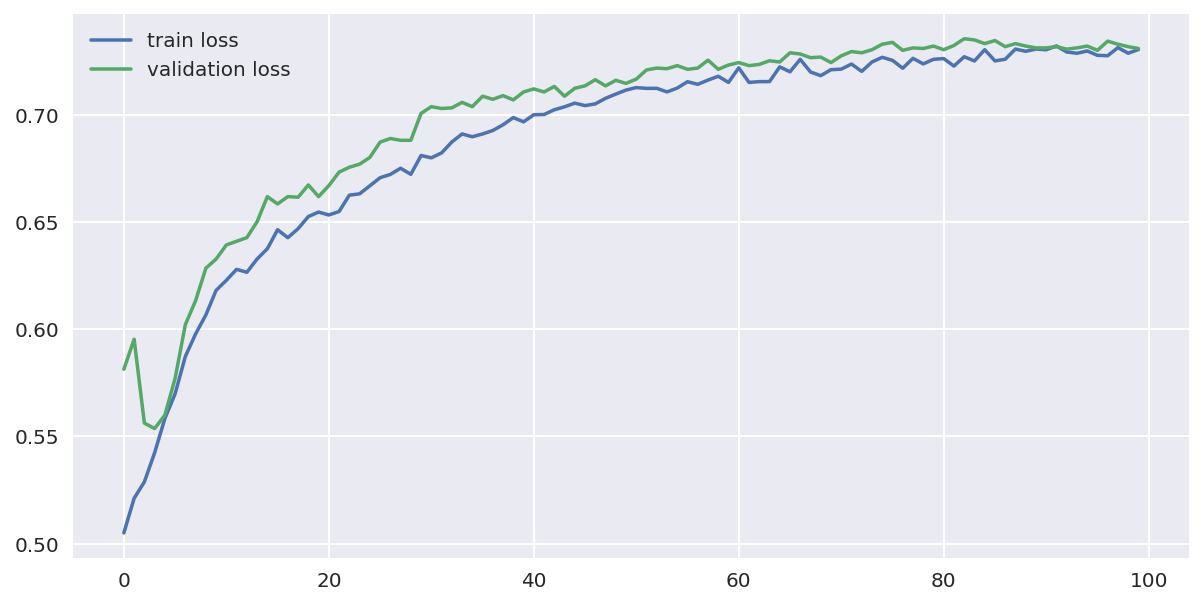

In [130]:
plot_losses(history.history['acc'], history.history['val_acc'], 1)

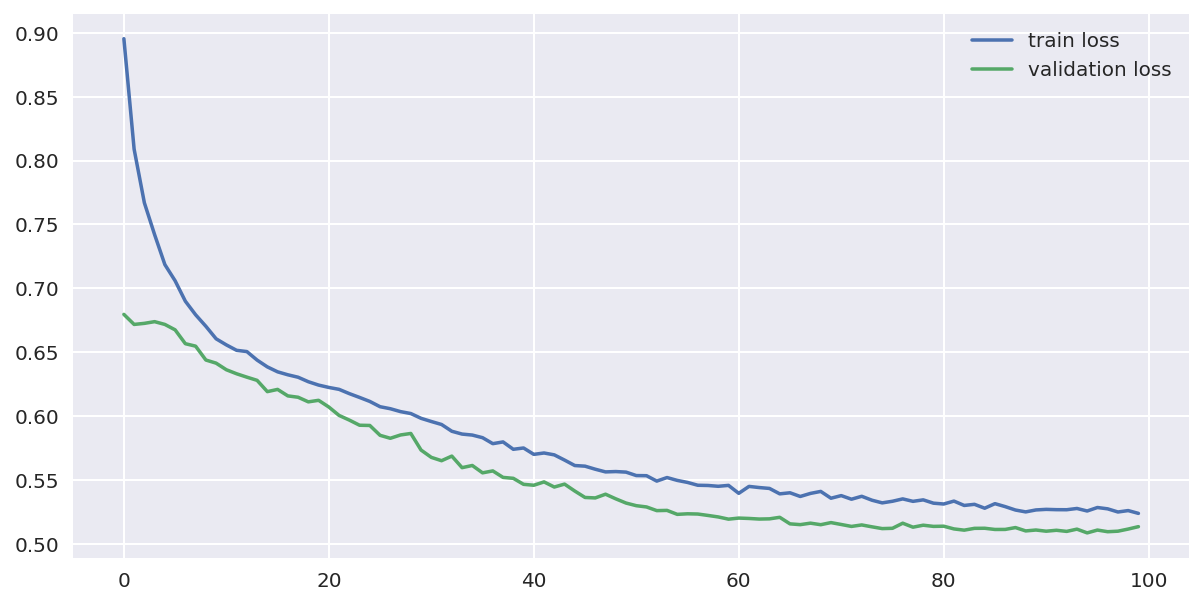

In [131]:
plot_losses(history.history['loss'], history.history['val_loss'], 1)

In [132]:
df_val

,Model,Fold,ROC-AUC,G-mean,F1-Score,TPR,TNR,Accuracy,Precision,Recall,Logloss,Description
0,CNN,Erk.csv,0.819284,0.711689,0.769268,0.89726,0.564498,0.730879,0.673233,0.89726,0.513464,single-batch


In [133]:
df_test

,Model,Fold,ROC-AUC,G-mean,F1-Score,TPR,TNR,Accuracy,Precision,Recall,Logloss,Description
0,CNN,Erk.csv,0.643591,0.603116,0.005555,0.632576,0.575029,0.575137,0.00279,0.632576,0.606158,single-batch


In [135]:
df_val, df_test, history, model = fit_base_learner(X_tra, y_tra, X_val, y_val, random_state)

Train on 31524 samples, validate on 3504 samples
Epoch 1/100
29696/31524 [===========================>..] - ETA: 0s - loss: 0.9891 - acc: 0.5078
Epoch 00001: val_loss improved from inf to 0.69333, saving model to _data/model.best.hdf5
31524/31524 [==============================] - 4s 132us/step - loss: 0.9845 - acc: 0.5080 - val_loss: 0.6933 - val_acc: 0.5337
Epoch 2/100
29696/31524 [===========================>..] - ETA: 0s - loss: 0.8747 - acc: 0.5235
Epoch 00002: val_loss improved from 0.69333 to 0.68590, saving model to _data/model.best.hdf5
31524/31524 [==============================] - 1s 43us/step - loss: 0.8706 - acc: 0.5250 - val_loss: 0.6859 - val_acc: 0.5371
Epoch 3/100
29696/31524 [===========================>..] - ETA: 0s - loss: 0.8145 - acc: 0.5329
Epoch 00003: val_loss improved from 0.68590 to 0.68265, saving model to _data/model.best.hdf5
31524/31524 [==============================] - 1s 43us/step - loss: 0.8138 - acc: 0.5328 - val_loss: 0.6827 - val_acc: 0.5454
Epoch 

In [136]:
results_val = pd.concat((results_val, df_val))
results_test = pd.concat((results_test, df_test))
histories.append(history)
models.append(model)

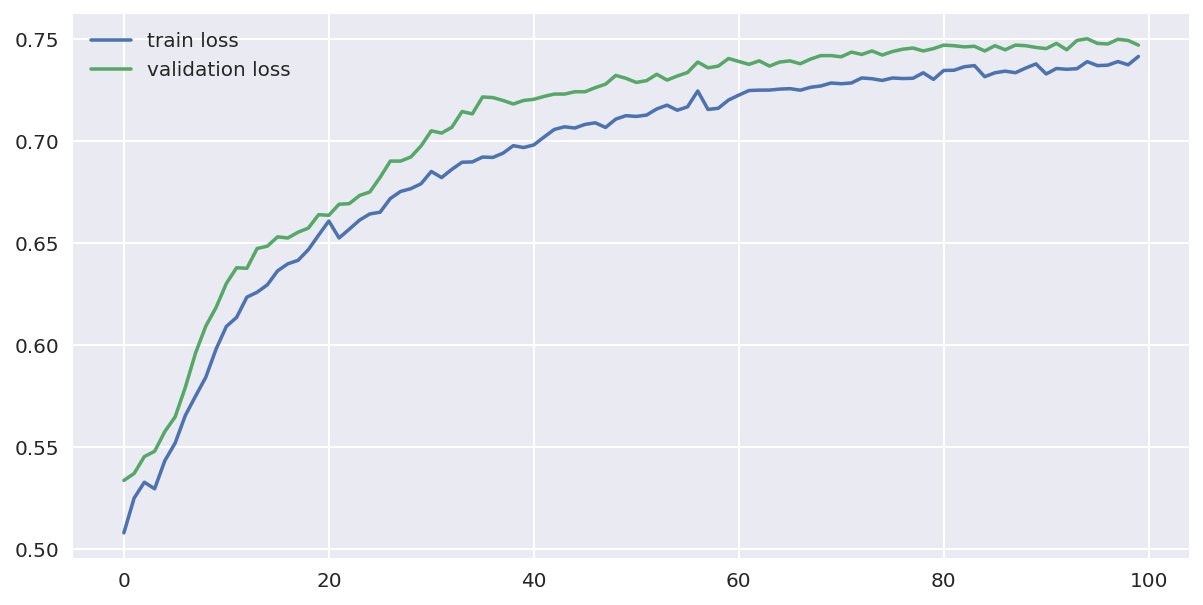

In [137]:
plot_losses(history.history['acc'], history.history['val_acc'], 1)

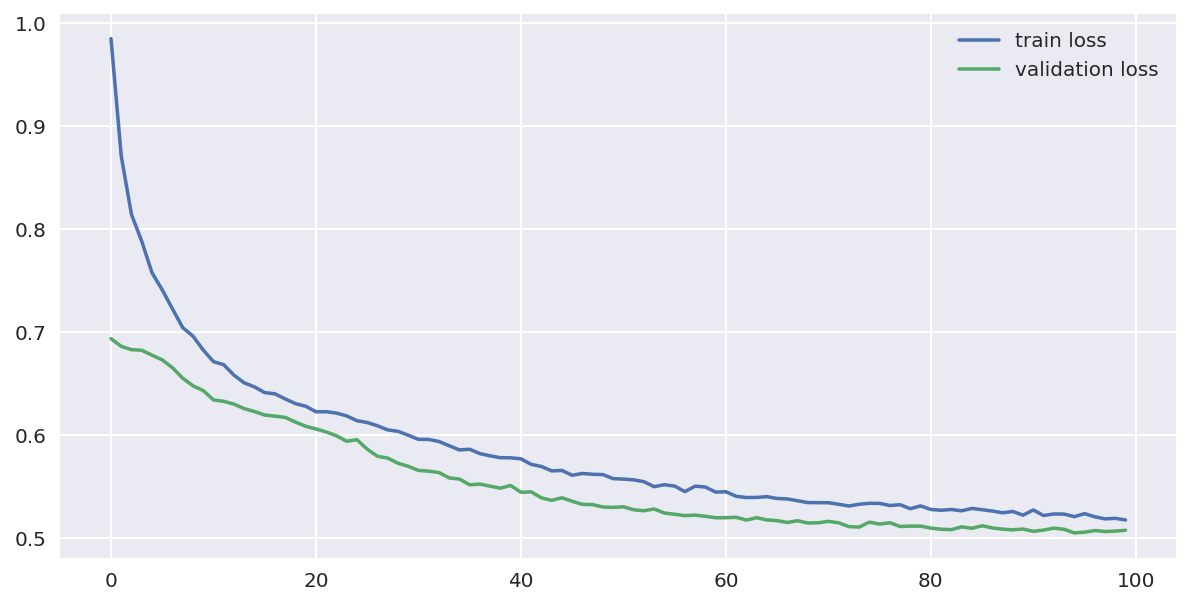

In [138]:
plot_losses(history.history['loss'], history.history['val_loss'], 1)

In [139]:
results_val

,Model,Fold,ROC-AUC,G-mean,F1-Score,TPR,TNR,Accuracy,Precision,Recall,Logloss,Description
0,CNN,Erk.csv,0.819284,0.711689,0.769268,0.89726,0.564498,0.730879,0.673233,0.89726,0.513464,single-batch
0,CNN,Erk.csv,0.819415,0.733047,0.778527,0.88984,0.603881,0.746861,0.691966,0.88984,0.507383,single-batch


In [140]:
results_test

,Model,Fold,ROC-AUC,G-mean,F1-Score,TPR,TNR,Accuracy,Precision,Recall,Logloss,Description
0,CNN,Erk.csv,0.643591,0.603116,0.005555,0.632576,0.575029,0.575137,0.00279,0.632576,0.606158,single-batch
0,CNN,Erk.csv,0.643685,0.612308,0.005695,0.662879,0.565596,0.565778,0.00286,0.662879,0.630360,single-batch


In [142]:
df_val, df_test, history, model = fit_base_learner(X_tra, y_tra, X_val, y_val, random_state)

Train on 31524 samples, validate on 3504 samples
Epoch 1/100
29696/31524 [===========================>..] - ETA: 0s - loss: 0.9602 - acc: 0.5087
Epoch 00001: val_loss improved from inf to 0.68530, saving model to _data/model.best.hdf5
31524/31524 [==============================] - 5s 146us/step - loss: 0.9590 - acc: 0.5080 - val_loss: 0.6853 - val_acc: 0.5497
Epoch 2/100
29696/31524 [===========================>..] - ETA: 0s - loss: 0.8466 - acc: 0.5219
Epoch 00002: val_loss did not improve
31524/31524 [==============================] - 1s 41us/step - loss: 0.8457 - acc: 0.5218 - val_loss: 0.6882 - val_acc: 0.5422
Epoch 3/100
29696/31524 [===========================>..] - ETA: 0s - loss: 0.7966 - acc: 0.5296
Epoch 00003: val_loss improved from 0.68530 to 0.68243, saving model to _data/model.best.hdf5
31524/31524 [==============================] - 1s 42us/step - loss: 0.7956 - acc: 0.5305 - val_loss: 0.6824 - val_acc: 0.5451
Epoch 4/100
29696/31524 [===========================>..] - ETA

In [143]:
results_val = pd.concat((results_val, df_val))
results_test = pd.concat((results_test, df_test))
histories.append(history)
models.append(model)

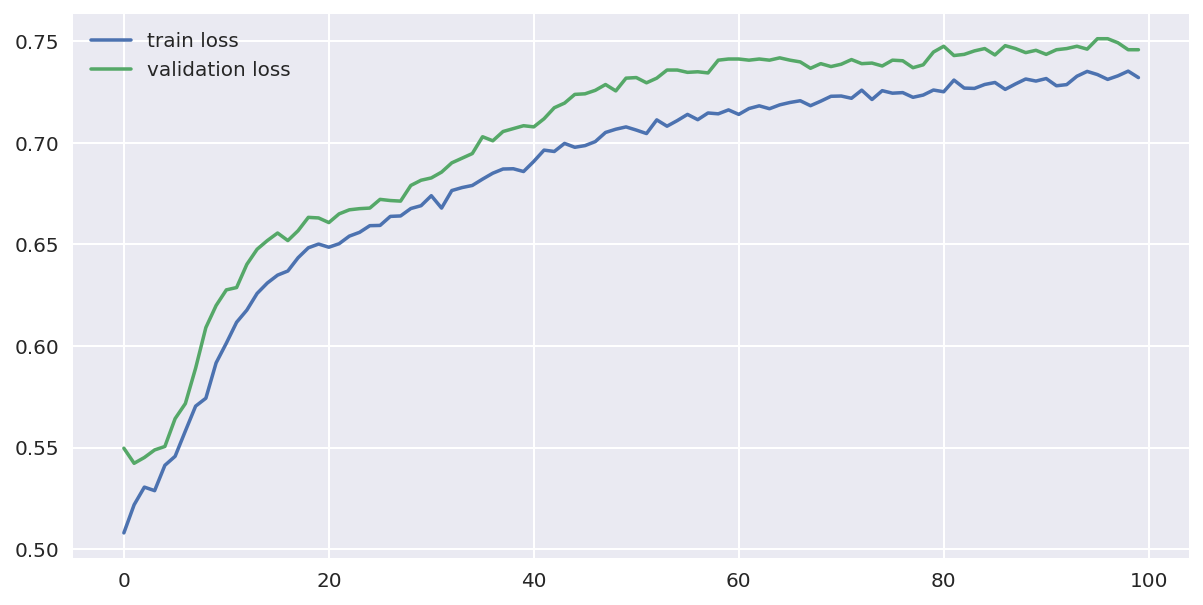

In [144]:
plot_losses(history.history['acc'], history.history['val_acc'], 1)

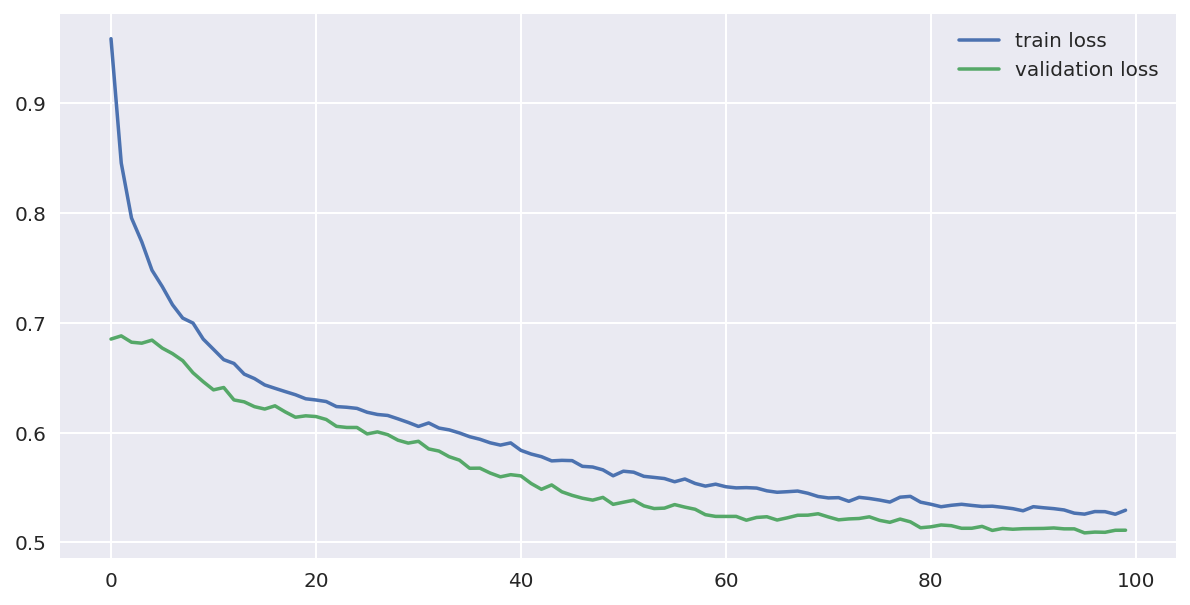

In [145]:
plot_losses(history.history['loss'], history.history['val_loss'], 1)

In [146]:
results_val

,Model,Fold,ROC-AUC,G-mean,F1-Score,TPR,TNR,Accuracy,Precision,Recall,Logloss,Description
0,CNN,Erk.csv,0.819284,0.711689,0.769268,0.897260,0.564498,0.730879,0.673233,0.897260,0.513464,single-batch
0,CNN,Erk.csv,0.819415,0.733047,0.778527,0.889840,0.603881,0.746861,0.691966,0.889840,0.507383,single-batch
0,CNN,Erk.csv,0.818038,0.730746,0.778634,0.894406,0.597032,0.745719,0.689397,0.894406,0.511137,single-batch


In [147]:
results_test

,Model,Fold,ROC-AUC,G-mean,F1-Score,TPR,TNR,Accuracy,Precision,Recall,Logloss,Description
0,CNN,Erk.csv,0.643591,0.603116,0.005555,0.632576,0.575029,0.575137,0.002790,0.632576,0.606158,single-batch
0,CNN,Erk.csv,0.643685,0.612308,0.005695,0.662879,0.565596,0.565778,0.002860,0.662879,0.630360,single-batch
0,CNN,Erk.csv,0.639082,0.604860,0.005522,0.662879,0.551920,0.552128,0.002773,0.662879,0.638558,single-batch


In [148]:
df_val, df_test, history, model = fit_base_learner(X_tra, y_tra, X_val, y_val, random_state)

Train on 31524 samples, validate on 3504 samples
Epoch 1/100
29696/31524 [===========================>..] - ETA: 0s - loss: 0.9767 - acc: 0.5093
Epoch 00001: val_loss improved from inf to 0.68584, saving model to _data/model.best.hdf5
31524/31524 [==============================] - 5s 161us/step - loss: 0.9724 - acc: 0.5101 - val_loss: 0.6858 - val_acc: 0.5405
Epoch 2/100
29696/31524 [===========================>..] - ETA: 0s - loss: 0.8817 - acc: 0.5163
Epoch 00002: val_loss improved from 0.68584 to 0.68583, saving model to _data/model.best.hdf5
31524/31524 [==============================] - 1s 44us/step - loss: 0.8804 - acc: 0.5163 - val_loss: 0.6858 - val_acc: 0.5402
Epoch 3/100
29696/31524 [===========================>..] - ETA: 0s - loss: 0.8242 - acc: 0.5201
Epoch 00003: val_loss improved from 0.68583 to 0.68243, saving model to _data/model.best.hdf5
31524/31524 [==============================] - 1s 44us/step - loss: 0.8241 - acc: 0.5197 - val_loss: 0.6824 - val_acc: 0.5425
Epoch 

In [149]:
results_val = pd.concat((results_val, df_val))
results_test = pd.concat((results_test, df_test))
histories.append(history)
models.append(model)

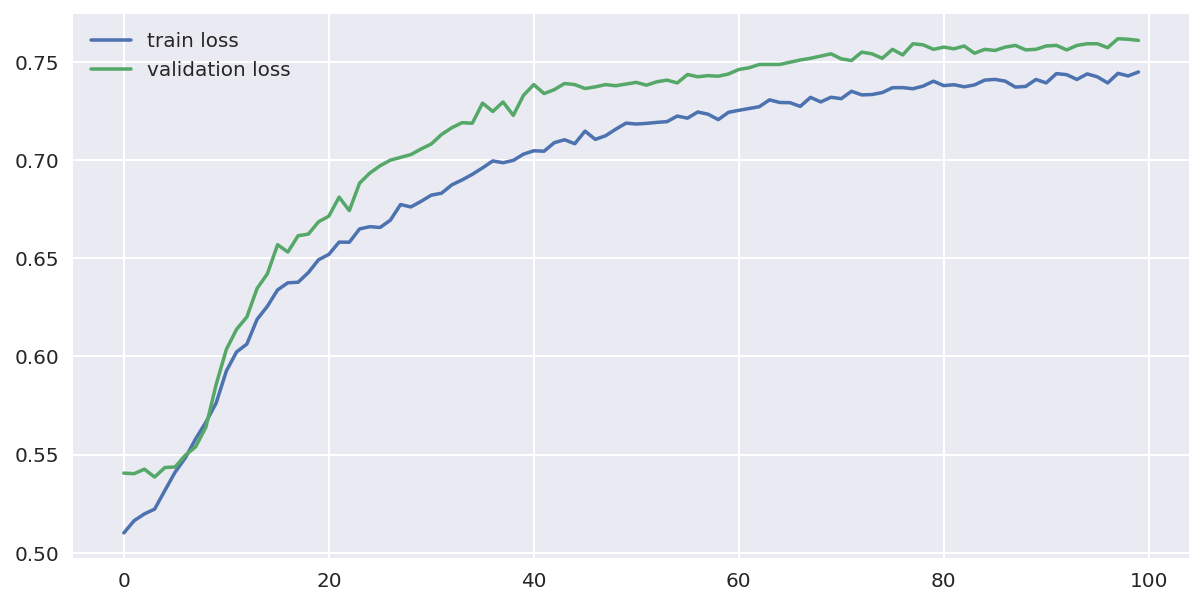

In [150]:
plot_losses(history.history['acc'], history.history['val_acc'], 1)

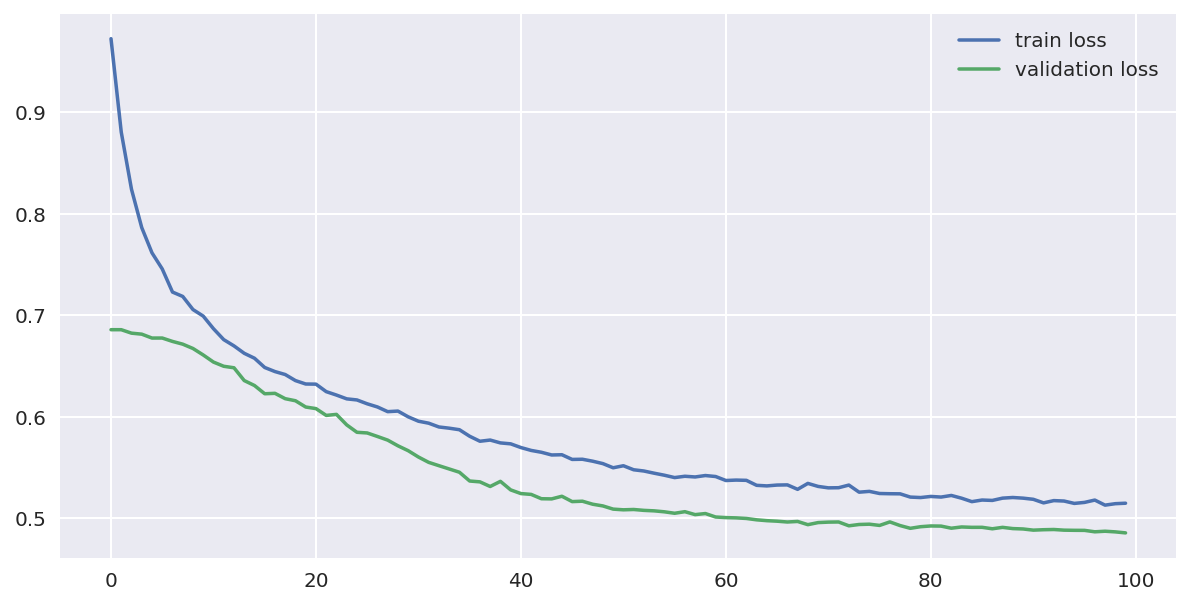

In [151]:
plot_losses(history.history['loss'], history.history['val_loss'], 1)

In [152]:
results_val

,Model,Fold,ROC-AUC,G-mean,F1-Score,TPR,TNR,Accuracy,Precision,Recall,Logloss,Description
0,CNN,Erk.csv,0.819284,0.711689,0.769268,0.897260,0.564498,0.730879,0.673233,0.897260,0.513464,single-batch
0,CNN,Erk.csv,0.819415,0.733047,0.778527,0.889840,0.603881,0.746861,0.691966,0.889840,0.507383,single-batch
0,CNN,Erk.csv,0.818038,0.730746,0.778634,0.894406,0.597032,0.745719,0.689397,0.894406,0.511137,single-batch
0,CNN,Erk.csv,0.833398,0.748227,0.790383,0.900685,0.621575,0.761130,0.704150,0.900685,0.485714,single-batch


In [153]:
results_test

,Model,Fold,ROC-AUC,G-mean,F1-Score,TPR,TNR,Accuracy,Precision,Recall,Logloss,Description
0,CNN,Erk.csv,0.643591,0.603116,0.005555,0.632576,0.575029,0.575137,0.002790,0.632576,0.606158,single-batch
0,CNN,Erk.csv,0.643685,0.612308,0.005695,0.662879,0.565596,0.565778,0.002860,0.662879,0.630360,single-batch
0,CNN,Erk.csv,0.639082,0.604860,0.005522,0.662879,0.551920,0.552128,0.002773,0.662879,0.638558,single-batch
0,CNN,Erk.csv,0.645626,0.598801,0.005362,0.693182,0.517271,0.517601,0.002692,0.693182,0.683158,single-batch


In [155]:
df_val, df_test, history, model = fit_base_learner(X_tra, y_tra, X_val, y_val, random_state)

Train on 31524 samples, validate on 3504 samples
Epoch 1/100
29696/31524 [===========================>..] - ETA: 0s - loss: 0.9331 - acc: 0.5040
Epoch 00001: val_loss improved from inf to 0.71993, saving model to _data/model.best.hdf5
31524/31524 [==============================] - 5s 158us/step - loss: 0.9290 - acc: 0.5055 - val_loss: 0.7199 - val_acc: 0.5131
Epoch 2/100
29696/31524 [===========================>..] - ETA: 0s - loss: 0.8446 - acc: 0.5174
Epoch 00002: val_loss improved from 0.71993 to 0.71330, saving model to _data/model.best.hdf5
31524/31524 [==============================] - 1s 43us/step - loss: 0.8435 - acc: 0.5178 - val_loss: 0.7133 - val_acc: 0.5128
Epoch 3/100
29696/31524 [===========================>..] - ETA: 0s - loss: 0.7972 - acc: 0.5226
Epoch 00003: val_loss improved from 0.71330 to 0.69763, saving model to _data/model.best.hdf5
31524/31524 [==============================] - 1s 44us/step - loss: 0.7967 - acc: 0.5221 - val_loss: 0.6976 - val_acc: 0.5234
Epoch 

In [156]:
results_val = pd.concat((results_val, df_val))
results_test = pd.concat((results_test, df_test))
histories.append(history)
models.append(model)

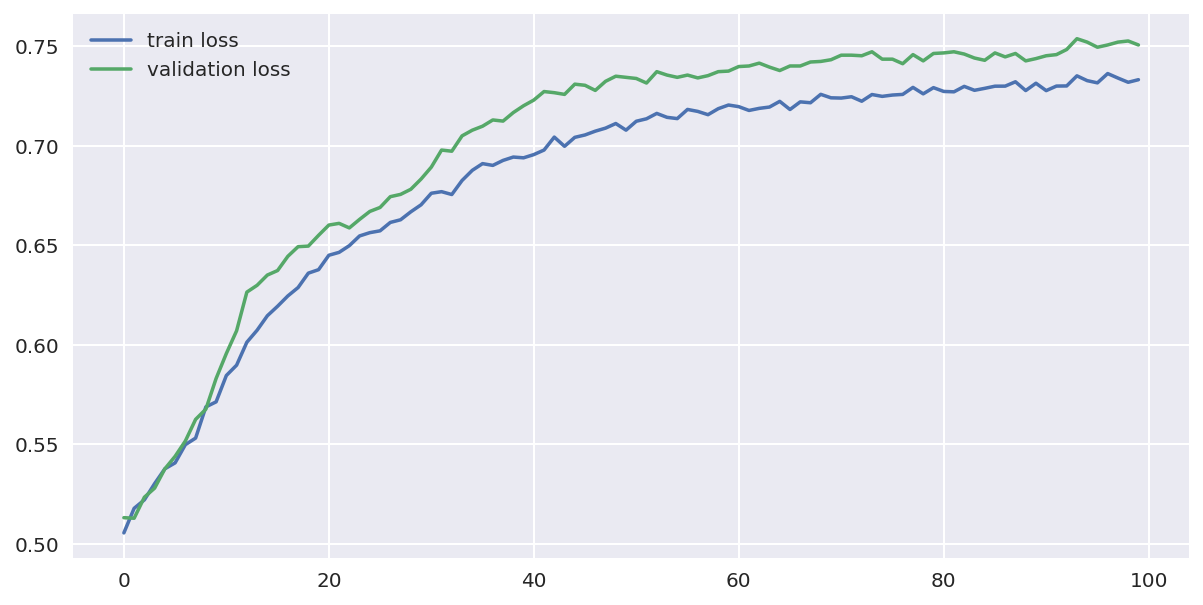

In [157]:
plot_losses(history.history['acc'], history.history['val_acc'], 1)

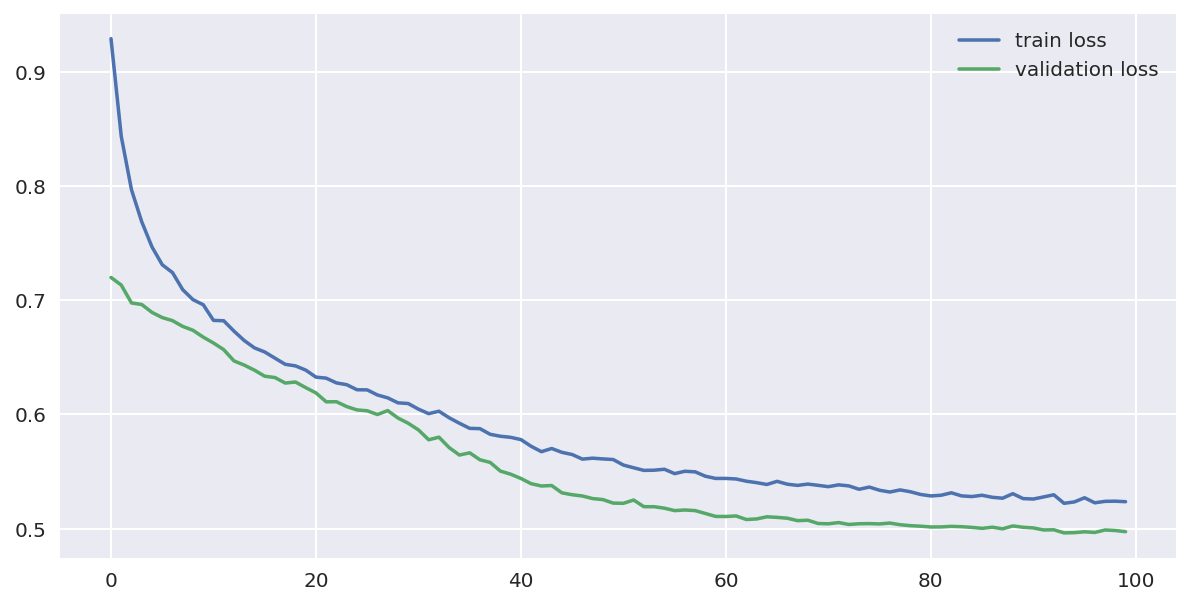

In [158]:
plot_losses(history.history['loss'], history.history['val_loss'], 1)

In [159]:
results_val

,Model,Fold,ROC-AUC,G-mean,F1-Score,TPR,TNR,Accuracy,Precision,Recall,Logloss,Description
0,CNN,Erk.csv,0.819284,0.711689,0.769268,0.897260,0.564498,0.730879,0.673233,0.897260,0.513464,single-batch
0,CNN,Erk.csv,0.819415,0.733047,0.778527,0.889840,0.603881,0.746861,0.691966,0.889840,0.507383,single-batch
0,CNN,Erk.csv,0.818038,0.730746,0.778634,0.894406,0.597032,0.745719,0.689397,0.894406,0.511137,single-batch
0,CNN,Erk.csv,0.833398,0.748227,0.790383,0.900685,0.621575,0.761130,0.704150,0.900685,0.485714,single-batch
0,CNN,Erk.csv,0.830033,0.738384,0.780181,0.885274,0.615868,0.750571,0.697392,0.885274,0.497376,single-batch


In [160]:
results_test

,Model,Fold,ROC-AUC,G-mean,F1-Score,TPR,TNR,Accuracy,Precision,Recall,Logloss,Description
0,CNN,Erk.csv,0.643591,0.603116,0.005555,0.632576,0.575029,0.575137,0.002790,0.632576,0.606158,single-batch
0,CNN,Erk.csv,0.643685,0.612308,0.005695,0.662879,0.565596,0.565778,0.002860,0.662879,0.630360,single-batch
0,CNN,Erk.csv,0.639082,0.604860,0.005522,0.662879,0.551920,0.552128,0.002773,0.662879,0.638558,single-batch
0,CNN,Erk.csv,0.645626,0.598801,0.005362,0.693182,0.517271,0.517601,0.002692,0.693182,0.683158,single-batch
0,CNN,Erk.csv,0.644052,0.612218,0.005881,0.613636,0.610803,0.610808,0.002955,0.613636,0.572401,single-batch


## Ensemble

In [161]:
y_preds = []
y_preds_proba = []
for model in models:
    y_pred = model.predict(X_test.reshape(-1, 9, 9, 1), batch_size=1024)
    y_pred_proba = model.predict_proba(X_test.reshape(-1, 9, 9, 1), batch_size=1024)
    y_preds.append(y_pred)
    y_preds_proba.append(y_pred_proba)
y_preds = np.array(y_preds)
y_preds_proba = np.array(y_preds_proba)

In [167]:
y_preds.shape, y_preds_proba.shape

((5, 140730, 1), (5, 140730, 2))

In [200]:
dissagreement = y_preds.sum(0).reshape(-1)

In [201]:
dissagreement.shape

(140730,)

In [202]:
dissagreement[np.array([0<x<5 for x in dissagreement])].shape

(34635,)

In [232]:
y_preds_avg = np.array([int(x>=3) for x in y_preds.sum(0).reshape(-1)]).reshape(-1, 1)
y_preds_proba_avg = y_preds_proba.sum(0) / 5

In [233]:
y_preds_avg.shape, y_preds_proba_avg.shape

((140730, 1), (140730, 2))

In [235]:
df_test = evaluate_metrics(y_test.reshape(-1), y_preds_avg, y_preds_proba_avg[:,1],
                              'CNN', test_fold, 'single-batch')

Confusion matrix:
[[78627 61839]
 [   85   179]]
  Model     Fold   ROC-AUC    G-mean  F1-Score      TPR       TNR  Accuracy  \
0   CNN  Erk.csv  0.648688  0.616063  0.005748  0.67803  0.559758   0.55998   

   Precision   Recall   Logloss   Description  
0   0.002886  0.67803  0.619114  single-batch  


In [236]:
results_test

,Model,Fold,ROC-AUC,G-mean,F1-Score,TPR,TNR,Accuracy,Precision,Recall,Logloss,Description
0,CNN,Erk.csv,0.643591,0.603116,0.005555,0.632576,0.575029,0.575137,0.002790,0.632576,0.606158,single-batch
0,CNN,Erk.csv,0.643685,0.612308,0.005695,0.662879,0.565596,0.565778,0.002860,0.662879,0.630360,single-batch
0,CNN,Erk.csv,0.639082,0.604860,0.005522,0.662879,0.551920,0.552128,0.002773,0.662879,0.638558,single-batch
0,CNN,Erk.csv,0.645626,0.598801,0.005362,0.693182,0.517271,0.517601,0.002692,0.693182,0.683158,single-batch
0,CNN,Erk.csv,0.644052,0.612218,0.005881,0.613636,0.610803,0.610808,0.002955,0.613636,0.572401,single-batch


In [237]:
df_test

,Model,Fold,ROC-AUC,G-mean,F1-Score,TPR,TNR,Accuracy,Precision,Recall,Logloss,Description
0,CNN,Erk.csv,0.648688,0.616063,0.005748,0.67803,0.559758,0.55998,0.002886,0.67803,0.619114,single-batch
